# Theoretical Modelling Analysis
This script will be used to generate plots for my thesis, in particular I'll generate each of the plots i need for the theoretical modelling analysis. This should be versatile enough to work for the ZFOURGE observational (semi-empirical) models, and the pure theoretical models.

In [1]:
import matplotlib.pyplot as plt
import astropy.units as u
import numpy as np
import pandas as pd
import os
from astLib import astSED
import astropy.io.fits as fits
from carf import * # custom module for functions relating to the project
import matplotlib.path as mpath


# So that we can change the helper functions without reloading the kernel
%load_ext autoreload
%autoreload 2

In [2]:
# Choose if you want to save the plots
save_figures = True
fig_size_params = (10, 6)

In [3]:
# We would like to investigate the effects of the different filters.
# Read in the dataframe

template_set_name = 'Brown'
agn_model_name = 'Type1AGN'

composite_choice = f'{template_set_name}_theoretical_composite_fluxes_{agn_model_name}'

# read in the dataframe and ensure that the unamed: 0 column is the index
composite_choice = f'{template_set_name}_theoretical_composite_fluxes_{agn_model_name}'
composite_fluxes = pd.read_csv(f'outputs\composite_seds\{composite_choice}.csv', index_col=0)   
# Reset the index
composite_fluxes.reset_index(drop=True, inplace=True)
# Drop the first col
#composite_fluxes = composite_fluxes.drop(columns=['Unnamed: 0.1'])

In [4]:
# Check outputs
composite_fluxes

# Check index column 
len(composite_fluxes.index.unique())

5120

In [5]:
# Check which IRAC filters are available (whatever begins with IRAC)
irac_filters = [col for col in composite_fluxes.columns if col.startswith('IRAC')]
print(irac_filters)


['IRAC3.6_0', 'IRAC3.6_10', 'IRAC3.6_20', 'IRAC3.6_30', 'IRAC3.6_40', 'IRAC3.6_50', 'IRAC3.6_60', 'IRAC3.6_70', 'IRAC3.6_80', 'IRAC3.6_90', 'IRAC3.6_100', 'IRAC4.5_0', 'IRAC4.5_10', 'IRAC4.5_20', 'IRAC4.5_30', 'IRAC4.5_40', 'IRAC4.5_50', 'IRAC4.5_60', 'IRAC4.5_70', 'IRAC4.5_80', 'IRAC4.5_90', 'IRAC4.5_100', 'IRAC5.8_0', 'IRAC5.8_10', 'IRAC5.8_20', 'IRAC5.8_30', 'IRAC5.8_40', 'IRAC5.8_50', 'IRAC5.8_60', 'IRAC5.8_70', 'IRAC5.8_80', 'IRAC5.8_90', 'IRAC5.8_100', 'IRAC8.0_0', 'IRAC8.0_10', 'IRAC8.0_20', 'IRAC8.0_30', 'IRAC8.0_40', 'IRAC8.0_50', 'IRAC8.0_60', 'IRAC8.0_70', 'IRAC8.0_80', 'IRAC8.0_90', 'IRAC8.0_100']


In [6]:
# Check for each entry of a particular filter, how many variations of it there are i.e U_0, U_10
# Allow us to have a robust way of investigating the effects of the different alpha values automatically, without recoding the filter names/alpha values

# Get the filters
filters = composite_fluxes.columns[2:]

# For the first filter, see how many variations there are
filter_choice = filters[0].split('_')[0]


# Get the variations
filter_variations = [filter for filter in filters if filter_choice in filter]

# add the alpha values to a new array
alpha_values = [int(filter.split('_')[1]) for filter in filter_variations]

# Print the alpha values
print(alpha_values)


[0, 10, 20, 30, 40, 50, 60, 70, 80, 90, 100]


## UVJ
### Plot
The code below will generate a subplot for the UVJ diagrams of the theoretical models. 

*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB o

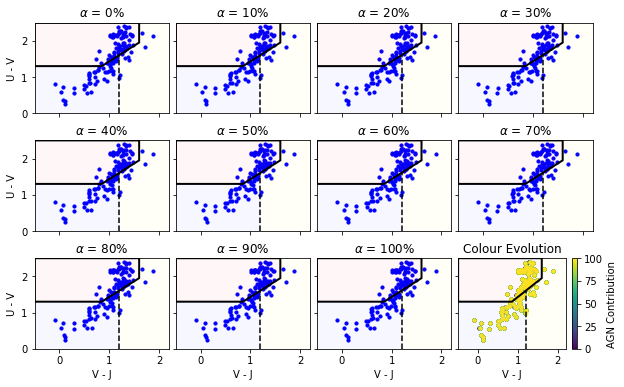

In [7]:
spacing = len(alpha_values)
colours_theme = plt.cm.viridis(np.linspace(0, 1, spacing))

# Galaxy Fractions - Quiescent, Star-forming, Dusty for each alpha value
galaxy_fractions = {'Star-forming': [], 'Quiescent': [], 'Dusty': []} # each key will have a list of fractions for each alpha value
num_galaxies = len(composite_fluxes[composite_fluxes['z'] == 0]) # number of galaxies in the composite_flux in the rest frame

fig, axs = plt.subplots(3, 4, figsize=fig_size_params, sharex=True, sharey=True)
for n in range(len(alpha_values)):
    # Get the filter magnitudes
    U_mag = composite_fluxes[f'U_{alpha_values[n]}']
    V_mag = composite_fluxes[f'V_{alpha_values[n]}']
    J_mag = composite_fluxes[f'J_{alpha_values[n]}']
    
    # Create the colours
    uv = U_mag - V_mag
    vj = V_mag - J_mag
    
    # Recall that this is only a restframe diagram, so only look at the restframe colours
    uv = uv[composite_fluxes['z'] == 0]
    vj = vj[composite_fluxes['z'] == 0]
    
    axs[n//4, n%4].scatter(vj, uv, c='blue', s=10)
    
    axs[n//4, n%4].set_xlim(-0.5, 2.2)
    axs[n//4, n%4].set_ylim(0, 2.5)
    
    # Plot AGN Contribution in the title 
    # alpha needs to be the alpha symbol
    #alpha_symbol = r'$\alpha$'
    axs[n//4, n%4].set_title(rf'$\alpha$ = {alpha_values[n]}%')
    
    # Define paths for selections
    path_quiescent = [[-0.5, 1.3], [0.85, 1.3], [1.6, 1.95], [1.6, 2.5], [-0.5, 2.5]]
    path_sf = [[-0.5, 0.0], [-0.5, 1.3], [0.85, 1.3], [1.2, 1.60333], [1.2, 0.0]]
    path_sfd = [[1.2, 0.0], [1.2, 1.60333], [1.6, 1.95], [1.6, 2.5], [2.2, 2.5], [2.2, 0.0]]
    
    # Add patches for selections
    axs[n//4, n%4].add_patch(plt.Polygon(path_quiescent, closed=True, fill=True, facecolor=(1, 0, 0, 0.03), edgecolor='k', linewidth=2, linestyle='solid'))
    axs[n//4, n%4].add_patch(plt.Polygon(path_sf, closed=True, fill=True, facecolor=(0, 0, 1, 0.03)))
    axs[n//4, n%4].add_patch(plt.Polygon(path_sfd, closed=True, fill=True, facecolor=(1, 1, 0, 0.03)))
    
    # Add vertical line
    axs[n//4, n%4].axvline(1.2, color='black', linestyle='--', ymin=0, ymax=1.60333/2.5)
    
    # Add axis labels
    if n//4 == 2:
        axs[n//4, n%4].set_xlabel("V - J")
    if n%4 == 0:
        axs[n//4, n%4].set_ylabel("U - V")
        
    
    # We will obtain the Star-forming, Quiescent, and Dusty Fractions for this particular alpha value     
    # Obtain the number of galaxies with sf region dictated by the sf path
    # Create Path objects from your path coordinates (do this once, outside the loop)
    path_quiescent_obj = mpath.Path(path_quiescent)
    path_sf_obj = mpath.Path(path_sf)
    path_sfd_obj = mpath.Path(path_sfd)

    # Create a DataFrame with just the uv and vj columns for easier selection
    uvj_data = pd.DataFrame({'vj': vj, 'uv': uv})

    # Perform the selection
    quiescent_seds = uvj_data[path_quiescent_obj.contains_points(uvj_data.values)]
    sf_seds = uvj_data[path_sf_obj.contains_points(uvj_data.values)]
    sfd_seds = uvj_data[path_sfd_obj.contains_points(uvj_data.values)]

    # Calculate the fractions
    galaxy_fractions['Quiescent'].append(len(quiescent_seds) / num_galaxies)
    galaxy_fractions['Star-forming'].append(len(sf_seds) / num_galaxies)
    galaxy_fractions['Dusty'].append(len(sfd_seds) / num_galaxies)
    

for m in range(len(alpha_values)):
    # Get the filter magnitudes
    U_mag = composite_fluxes[f'U_{alpha_values[m]}']
    V_mag = composite_fluxes[f'V_{alpha_values[m]}']
    J_mag = composite_fluxes[f'J_{alpha_values[m]}']
    
    # Create the colours
    uv = U_mag - V_mag
    vj = V_mag - J_mag
    
    # Recall that this is only a restframe diagram, so only look at the restframe colours
    uv = uv[composite_fluxes['z'] == 0]
    vj = vj[composite_fluxes['z'] == 0]
    
    # Plot scatter
    axs[2, 3].scatter(vj, uv, c=colours_theme[m], s=10)
    
    
# Add patches for selections
axs[2, 3].add_patch(plt.Polygon(path_quiescent, closed=True, fill=True, facecolor=(1, 0, 0, 0.03), edgecolor='k', linewidth=2, linestyle='solid'))
axs[2, 3].add_patch(plt.Polygon(path_sf, closed=True, fill=True, facecolor=(0, 0, 1, 0.03)))
axs[2, 3].add_patch(plt.Polygon(path_sfd, closed=True, fill=True, facecolor=(1, 1, 0, 0.03)))

# Add vertical line
axs[2, 3].axvline(1.2, color='black', linestyle='--', ymin=0, ymax=1.60333/2.5)

# Add axis labels
axs[2, 3].set_xlabel("V - J")

# AGN Colour Evolution title
axs[2, 3].set_title("Colour Evolution")



# Plot colorbar for AGN contribution
sm = plt.cm.ScalarMappable(cmap=plt.cm.viridis, norm=plt.Normalize(vmin=min(alpha_values), vmax=max(alpha_values)))
cbar = plt.colorbar(sm, ax=axs[2, 3])

# Name the colorbar
cbar.set_label('AGN Contribution')

    
# Make the subplots closer together
plt.subplots_adjust(wspace=0.05, hspace=0.3)
    

# Save the output
if save_figures:
    plt.savefig(f'outputs/ThesisPlots/UVJ_evolution_{agn_model_name}_{template_set_name}.png')

# Show the output
plt.show()


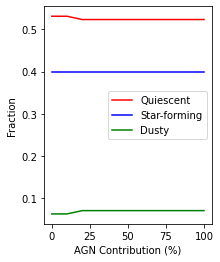

,Star-forming,Quiescent,Dusty
0,0.398438,0.531250,0.062500
10,0.398438,0.531250,0.062500
20,0.398438,0.523438,0.070312
30,0.398438,0.523438,0.070312
40,0.398438,0.523438,0.070312
50,0.398438,0.523438,0.070312
60,0.398438,0.523438,0.070312
70,0.398438,0.523438,0.070312
80,0.398438,0.523438,0.070312
90,0.398438,0.523438,0.070312


In [8]:
# Check the fractions 
galaxy_fractions

fraction_figsize = (3, 4)
# Plot the fractions
fig, ax = plt.subplots(figsize=fraction_figsize)
ax.plot(alpha_values, galaxy_fractions['Quiescent'], label='Quiescent', color='red')
ax.plot(alpha_values, galaxy_fractions['Star-forming'], label='Star-forming', color='blue')
ax.plot(alpha_values, galaxy_fractions['Dusty'], label='Dusty', color='Green')

# Add labels
ax.set_xlabel(f'AGN Contribution (%)')
ax.set_ylabel('Fraction')
#ax.set_title('Fraction of Galaxies in UVJ Diagram')
ax.legend()

# Save the output
if save_figures:
    plt.savefig(f'outputs/ThesisPlots/UVJ_galfractions_{agn_model_name}_{template_set_name}.png')
    
# Show the output
plt.show()

# Also convert the fractions to a dataframe
galaxy_fractions_df = pd.DataFrame(galaxy_fractions, index=alpha_values)



if save_figures:
    galaxy_fractions_df.to_csv(f'outputs/ThesisPlots/UVJ_fractions_{agn_model_name}_{template_set_name}.csv')

galaxy_fractions_df

### Metrics
These will be used to analyze the results from the UVJ diagram above

## ugr
### Plot

[0.  0.1 0.2 0.3 0.4 0.5 0.6 0.7 0.8 0.9 1.  1.1 1.2 1.3 1.4 1.5 1.6 1.7
 1.8 1.9 2.  2.1 2.2 2.3 2.4 2.5 2.6 2.7 2.8 2.9 3.  3.1 3.2 3.3 3.4 3.5
 3.6 3.7 3.8 3.9]
Correct Identification: 852
Correct Non-UGR Identification: 3700
Misidentification: 140
Missed Selection: 428
Correct Identification: 851
Correct Non-UGR Identification: 3700
Misidentification: 140
Missed Selection: 429
Correct Identification: 849
Correct Non-UGR Identification: 3702
Misidentification: 138
Missed Selection: 431
Correct Identification: 848
Correct Non-UGR Identification: 3702
Misidentification: 138
Missed Selection: 432


<ipython-input-9-8bb285bd4aa6>:90: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  selected_seds['redshift'] = redshifts_selected
<ipython-input-9-8bb285bd4aa6>:91: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  non_selected_seds['redshift'] = redshifts_non_selected
<ipython-input-9-8bb285bd4aa6>:90: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/

Correct Identification: 847
Correct Non-UGR Identification: 3702
Misidentification: 138
Missed Selection: 433
Correct Identification: 848
Correct Non-UGR Identification: 3702
Misidentification: 138
Missed Selection: 432
Correct Identification: 844
Correct Non-UGR Identification: 3702
Misidentification: 138
Missed Selection: 436
Correct Identification: 843
Correct Non-UGR Identification: 3703
Misidentification: 137
Missed Selection: 437
Correct Identification: 842
Correct Non-UGR Identification: 3703
Misidentification: 137
Missed Selection: 438
Correct Identification: 843
Correct Non-UGR Identification: 3702
Misidentification: 138
Missed Selection: 437
Correct Identification: 842
Correct Non-UGR Identification: 3703
Misidentification: 137
Missed Selection: 438


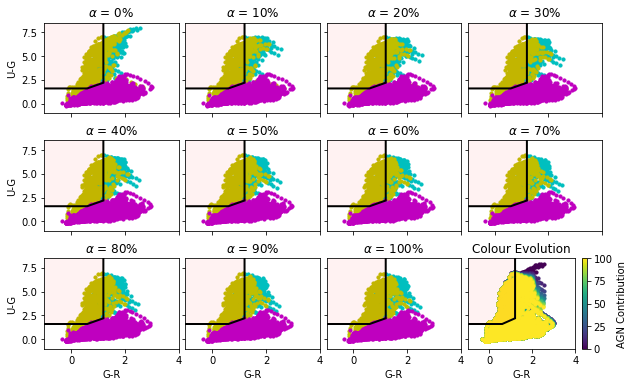

In [9]:
# We can do this a few ways
# We can either do a similar plot to above
# or we can do similar to sam's thesis work

# Essentially we want to quantify the values for missed selection, misidentifications, and correct identifications
# and see how those change with the alpha values

selection_statistics = {'Missed Selection': [], 'Misidentification': [], 'Correct Identification': [], 'Correct Non-UGR Identification': []}
# Realistically we are only interested in the correct identification and missed selection, but we will include all.
num_galaxies = len(composite_fluxes) # Because we consider all redshit ranges

# Completeness and contamination table
completeness_stats = {'Completeness': [] }

# The true values exsist for each of these regions - as we have developed the code to see if a galaxy is in a particular region
# and we know the redshift (as we artifically redshifted the galaxy

print(composite_fluxes['z'].unique())

# ugr Diagram 
fig, axs = plt.subplots(3, 4, figsize=fig_size_params, sharex=True, sharey=True)
for n in range(len(alpha_values)):
    # Get the u, g, and r magnitudes for the specific alpha value
    u_col_name = f'u_{int(round(alpha_values[n], 2))}'
    g_col_name = f'g_{int(round(alpha_values[n], 2))}'
    r_col_name = f'r_{int(round(alpha_values[n], 2))}'
    
    # Create the colours for the UGR diagram
    ug_specific_alpha_colours = composite_fluxes[u_col_name] - composite_fluxes[g_col_name]
    gr_specific_alpha_colours = composite_fluxes[g_col_name] - composite_fluxes[r_col_name]

    # Scatter plots with color-coded redshift ranges
    axs[n // 4, n % 4].scatter(gr_specific_alpha_colours[composite_fluxes['z'] > 3.5], 
                               ug_specific_alpha_colours[composite_fluxes['z'] > 3.5], 
                               c="c", s=10, label="z > 3.5")

    axs[n // 4, n % 4].scatter(gr_specific_alpha_colours[(composite_fluxes['z'] > 2.6) & (composite_fluxes['z'] <= 3.5)], 
                               ug_specific_alpha_colours[(composite_fluxes['z'] > 2.6) & (composite_fluxes['z'] <= 3.5)], 
                               c="y", s=10, label="2.6 < z < 3.5")

    axs[n // 4, n % 4].scatter(gr_specific_alpha_colours[composite_fluxes['z'] < 2.6], 
                               ug_specific_alpha_colours[composite_fluxes['z'] < 2.6], 
                               c="m", s=10, label="z < 2.6")
    
    
    # Set the AGN Contribution title 
    axs[n//4, n%4].set_title(rf'$\alpha$ = {alpha_values[n]}%')
    
    plt.xlabel("")
    plt.ylabel("")
    #plt.title("UGR Diagram for SED Templates at Different Redshifts(0 < z < 4) for alpha = {}".format(alphas[n]))

      
    # Set the axis labels
    if n//4 == 2:
        axs[n//4, n%4].set_xlabel("G-R")
    if n%4 == 0:
        axs[n//4, n%4].set_ylabel("U-G")
    
    
    # add the alpha value information onto the plot somewhere
    #axs[n//4, n%4].text(0.5, 0.9, f"alpha = {round(alpha[n], 2)}", horizontalalignment='center', verticalalignment='center', transform=axs[n//4, n%4].transAxes)

    # Additionally we can plot the UGR selection criteria on the UGR diagram
    U_rule = [[1.2,9], [1.2,2.2], [0.6,1.6], [-3,1.6], [-3,9]]
    axs[n//4, n%4].add_patch(plt.Polygon(U_rule, closed=True, fill=True, facecolor=(1,0,0,0.05), edgecolor=(0,0,0,1), linewidth=2, linestyle='solid')) # This looks like the correct U dropout technique
    
    
    # The path here is the UGR selection criteria, we can find the selected points in this particular population using the path
    # Create Path objects from your path coordinates (do this once, outside the loop)
    path = mpath.Path(U_rule)
    
    # Create a DataFrame with just the u-g and g-r columns for easier selection
    ugr_data = pd.DataFrame({'gr': gr_specific_alpha_colours, 'ug': ug_specific_alpha_colours})
    
    # append the associated redshifts to the ugr data
    redshifts = composite_fluxes['z']
    
    
    
    # Perform the selection
    selected_seds = ugr_data[path.contains_points(ugr_data.values)]
    non_selected_seds = ugr_data[~path.contains_points(ugr_data.values)]
    
    # Using the id of the selected seds, we can find the associated redshift values
    redshifts_selected = redshifts[selected_seds.index]
    redshifts_non_selected = redshifts[non_selected_seds.index]
    
    # We can then append the redshifts to the selected seds
    selected_seds['redshift'] = redshifts_selected
    non_selected_seds['redshift'] = redshifts_non_selected
    
    # using the above data we can calculate the fractions
    correct_ugr_selection = selected_seds[(selected_seds['redshift'] >= 2.6) & (selected_seds['redshift'] <= 3.5)]
    correct_nonugr_selection = non_selected_seds[(non_selected_seds['redshift'] < 2.6) | (non_selected_seds['redshift'] > 3.5)]
    
    # Combine the above to be a correct identification
    #correct_identification = correct_ugr_selection.append(correct_nonugr_selection)
    
    # Misidentification - a selected sed that was not in the redshift range we were after - incorrect redshift range
    misidentification = selected_seds[(selected_seds['redshift'] < 2.6) | (selected_seds['redshift'] > 3.5)]
    
    # Missed Selection - a non-selected sed SED that was in the redshift range we were after, something we missed.
    missed_selection = non_selected_seds[(non_selected_seds['redshift'] >= 2.6) & (non_selected_seds['redshift'] <= 3.5)]
    
    
    # Print the numbers without the fractions
    print(f"Correct Identification: {len(correct_ugr_selection)}")
    print(f"Correct Non-UGR Identification: {len(correct_nonugr_selection)}")
    print(f"Misidentification: {len(misidentification)}")
    print(f"Missed Selection: {len(missed_selection)}")
    
    
    
    
    # # Calculate the fractions
    # selection_statistics['Correct Identification'].append(len(correct_ugr_selection) / num_galaxies)
    # selection_statistics['Correct Non-UGR Identification'].append(len(correct_nonugr_selection) / num_galaxies)
    # selection_statistics['Misidentification'].append(len(misidentification) / num_galaxies)
    # selection_statistics['Missed Selection'].append(len(missed_selection) / num_galaxies)
    
    # Instead of fractions, we can just append the numbers
    selection_statistics['Correct Identification'].append(len(correct_ugr_selection))
    selection_statistics['Correct Non-UGR Identification'].append(len(correct_nonugr_selection))
    selection_statistics['Misidentification'].append(len(misidentification))
    selection_statistics['Missed Selection'].append(len(missed_selection))
    
    # We can also quantify the completeness and contamination of the selection
    # Completeness = Correct Identification / (Correct Identification + Missed Selection)
    # Contamination = Misidentification / (Correct Identification + Misidentification)
    
    completeness = len(correct_ugr_selection) / (len(correct_ugr_selection) + len(missed_selection))
    #contamination = len(misidentification) / (len(correct_ugr_selection) + len(misidentification))
    
    # Append the values
    completeness_stats['Completeness'].append(completeness)
    #completeness_stats['Contamination'].append(contamination)
    
    
    axs[n//4, n%4].set_xlim(-1, 4)
    axs[n//4, n%4].set_ylim(-1, 8.5)
    
for m in range(len(alpha_values)):
    
    
    
    # Recall that this is only a restframe diagram, so only look at the restframe colours
    u_col_name = f'u_{int(round(alpha_values[m], 2))}'
    g_col_name = f'g_{int(round(alpha_values[m], 2))}'
    r_col_name = f'r_{int(round(alpha_values[m], 2))}'
    
    # Create the colours for the UGR diagram
    ug_specific_alpha_colours = composite_fluxes[u_col_name] - composite_fluxes[g_col_name]
    gr_specific_alpha_colours = composite_fluxes[g_col_name] - composite_fluxes[r_col_name]
    
    # Scatter plots with color-coded redshift ranges
    axs[2, 3].scatter(gr_specific_alpha_colours, 
                               ug_specific_alpha_colours, 
                               c=colours_theme[m], s=10)


    
    
    # In addition we can plot a mean position for on each of the alpha plots. This mean value will be the mean of the ugr

# Additionally we can plot the UGR selection criteria on the UGR diagram
U_rule = [[1.2,9], [1.2,2.2], [0.6,1.6], [-3,1.6], [-3,9]]
axs[2, 3].add_patch(plt.Polygon(U_rule, closed=True, fill=True, facecolor=(1,0,0,0.05), edgecolor=(0,0,0,1), linewidth=2, linestyle='solid')) # This looks like the correct U dropout technique

axs[2, 3].set_xlim(-1, 4)
axs[2, 3].set_ylim(-1, 8.5)

axs[2, 3].set_xlabel("G-R")



# Add a colorbar for the AGN contribution
sm = plt.cm.ScalarMappable(cmap=plt.cm.viridis, norm=plt.Normalize(vmin=min(alpha_values), vmax=max(alpha_values)))
cbar = plt.colorbar(sm, ax=axs[2, 3])

# Add the colorbar label
cbar.set_label('AGN Contribution')

# add the final subplot labels
axs[2, 3].set_title("Colour Evolution")


# # Make all the plots touch

    
# Make the subplots closer together
plt.subplots_adjust(wspace=0.05, hspace=0.3)
    

if save_figures:
    plt.savefig(f'outputs/ThesisPlots/ugr_evolution_{agn_model_name}_{template_set_name}.png')
    
# Plot
plt.show()
    

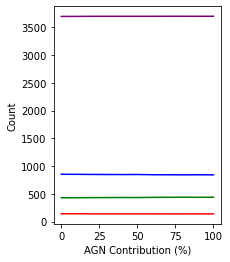

In [10]:
selection_statistics_df = pd.DataFrame(selection_statistics, index=alpha_values)

# Plot the fractions
fig, ax = plt.subplots(figsize=(3, 4))
ax.plot(alpha_values, selection_statistics['Correct Identification'], label='Correct Identification', color='blue')
ax.plot(alpha_values, selection_statistics['Misidentification'], label='Misidentification', color='red')
ax.plot(alpha_values, selection_statistics['Missed Selection'], label='Missed Selection', color='green')
ax.plot(alpha_values, selection_statistics['Correct Non-UGR Identification'], label='Correct Non-UGR Identification', color='purple')

# Add labels
ax.set_xlabel(f'AGN Contribution (%)')
ax.set_ylabel('Count')
#ax.set_title('Fraction of Galaxies in UGR Diagram')
# ax.legend()

# Save the output
if save_figures:
    plt.savefig(f'outputs/ThesisPlots/ugr_selection_fractions_{agn_model_name}_{template_set_name}.png')
    
# Show the output
plt.show()

selection_statistics_df

# We would like to output the selection statistics to a csv file
if save_figures:
    selection_statistics_df.to_csv(f'outputs/ThesisPlots/ugr_selection_fractions_{agn_model_name}_{template_set_name}.csv')
    

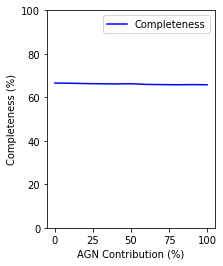

In [11]:
# Also plot the completeness and contamination statistics for each alpha
completeness_stats_df = pd.DataFrame(completeness_stats, index=alpha_values)

# add new column for completeness (convert to percentages)
completeness_stats_df['Completeness (%)'] = completeness_stats_df['Completeness'] * 100

# Plot the fractions
fig, ax = plt.subplots(figsize=(3, 4))

# Plot the completeness percentages
ax.plot(alpha_values, completeness_stats_df['Completeness (%)'], label='Completeness', color='blue')

# Add labels
ax.set_xlabel(f'AGN Contribution (%)')
ax.set_ylabel('Completeness (%)')
#ax.set_title('Fraction of Galaxies in UGR Diagram')
ax.legend()


# Set the ylim to 100
ax.set_ylim(0, 100)

# Save the output
if save_figures:
    plt.savefig(f'outputs/ThesisPlots/ugr_completeness_contamination_{agn_model_name}_{template_set_name}.png')
    
# Show the output
plt.show()

completeness_stats_df

# change the index to a column named alpha
# Create new column for alpha
completeness_stats_df['AGN Contribution (%)'] = completeness_stats_df.index
completeness_stats_df.reset_index(inplace=False).copy()

# Save the completeness percentages and AGN contribution to a csv file
if save_figures:
    completeness_stats_df[['AGN Contribution (%)', 'Completeness (%)']].to_csv(f'outputs/ThesisPlots/ugr_completeness_Contribution_{agn_model_name}_{template_set_name}.csv')

In [12]:
# # # For each of the alpha values, we can plot the counts

# fig, axs = plt.subplots(2, 2, figsize=(10, 10), sharex=True, sharey=True)

# # Plot the correct identification
# axs[0, 0].bar(alpha_values, selection_statistics['Correct Identification'], color='blue')
# axs[0, 0].set_title('Correct Identification')

# # Plot the misidentification
# axs[0, 1].bar(alpha_values, selection_statistics['Misidentification'], color='red')
# axs[0, 1].set_title('Misidentification')

# # Plot the missed selection
# axs[1, 0].bar(alpha_values, selection_statistics['Missed Selection'], color='green')
# axs[1, 0].set_title('Missed Selection')

# # Plot the correct non-ugr identification
# axs[1, 1].bar(alpha_values, selection_statistics['Correct Non-UGR Identification'], color='purple')
# axs[1, 1].set_title('Correct Non-UGR Identification')

# # Add labels
# for ax in axs.flat:
#     ax.set(xlabel='AGN Contribution (%)', ylabel='Counts')
    
# # Make the subplots closer together
# plt.subplots_adjust(wspace=0.05, hspace=0.3)

# # Save the output
# if save_figures:
#     plt.savefig(f'outputs/ThesisPlots/ugr_counts_{agn_model_name}_{template_set_name}.png')

    
# # Show the output
# plt.show()

# Plot

### Metrics

## IRAC 
### Plot


*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB o

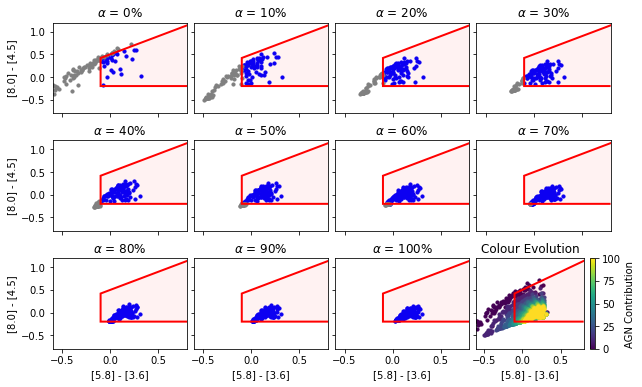

In [13]:
# Choose the diagram min and max
xmax = 0.8
ymax = 1.2
xmin = -0.6
ymin = -0.8

# Can change this to ensure we are only looking at the rest frame stuff
upper_redshift_limit = 0
lower_redshift_limit = 0
# setup 
fig, axs = plt.subplots(3, 4, figsize=fig_size_params, sharex=True, sharey=True)
for n in range(len(alpha_values)):
    
    # Get the IRAC magnitudes
    f_36 = composite_fluxes[f'IRAC3.6_{alpha_values[n]}']
    f_45 = composite_fluxes[f'IRAC4.5_{alpha_values[n]}']
    f_58 = composite_fluxes[f'IRAC5.8_{alpha_values[n]}']
    f_80 = composite_fluxes[f'IRAC8.0_{alpha_values[n]}']
    
    # Create the colours for the IRAC diagram
    f_5836_specific_alpha_colours = np.log10(f_58/f_36)
    f_8045_specific_alpha_colours = np.log10(f_80/f_45)

    # Redefine x and y for the first alpha value to plot the wedge
    x = f_5836_specific_alpha_colours
    y = f_8045_specific_alpha_colours
    
    
    
    x = x[(composite_fluxes['z'] >= lower_redshift_limit) & (composite_fluxes['z'] <= upper_redshift_limit)]
    y = y[(composite_fluxes['z'] >= lower_redshift_limit) & (composite_fluxes['z'] <= upper_redshift_limit)]
    
    
    
    # Reimplement the selection criteria 
    lacy_selection_condition = (x > -0.1) & (y > -0.2) & (y < 0.8 * x + 0.5)
    
    # Colour code for each alpha
    axs[n//4, n%4].scatter(x[lacy_selection_condition], y[lacy_selection_condition], c='blue', s=10)
    axs[n//4, n%4].scatter(x[~lacy_selection_condition], y[~lacy_selection_condition], c='grey', s=10)
    
    
    # Get the IRAC magnitudes
    f_36 = composite_fluxes[f'IRAC3.6_{alpha_values[0]}']
    f_45 = composite_fluxes[f'IRAC4.5_{alpha_values[0]}']
    f_58 = composite_fluxes[f'IRAC5.8_{alpha_values[0]}']
    f_80 = composite_fluxes[f'IRAC8.0_{alpha_values[0]}']
    
    # Create the colours for the IRAC diagram
    f_5836_specific_alpha_colours = np.log10(f_58/f_36)
    f_8045_specific_alpha_colours = np.log10(f_80/f_45)
    
    
    # Redefine x and y for the first alpha value to plot the wedge
    x = f_5836_specific_alpha_colours
    y = f_8045_specific_alpha_colours
    
    # # Ensure we are only looking at the rest frame stuff
    # x = x[composite_fluxes['z'] == 0]
    # y = y[composite_fluxes['z'] == 0]
      # Can change this to ensure we are only looking at the rest frame stuff
    x = x[(composite_fluxes['z'] >= lower_redshift_limit) & (composite_fluxes['z'] <= upper_redshift_limit)]
    y = y[(composite_fluxes['z'] >= lower_redshift_limit) & (composite_fluxes['z'] <= upper_redshift_limit)]
    
    # # Reimplement the selection criteria
    lacy_selection_condition = (x > -0.1) & (y > -0.2) & (y < 0.8 * x + 0.5)
    wedge_vertices = [
        (xmax, -0.2),
        (-0.1, -0.2),
        (-0.1, 0.8*np.nanmin(x[lacy_selection_condition]) + 0.5 if np.any(lacy_selection_condition) else -0.2),  # Handle empty selection
        (((ymax-0.5)/0.8), ymax)
    ] 
    wedge_polygon = plt.Polygon(wedge_vertices, closed=False, edgecolor='r', facecolor=(1,0,0,0.05), linestyle='-', linewidth=2, label='Lacy Wedge')
    # Plot the polygon on the subplot
    axs[n//4, n%4].add_patch(wedge_polygon)
    
    
    # Set the AGN Contribution title
    axs[n//4, n%4].set_title(rf'$\alpha$ = {alpha_values[n]}%')
    
    # Set the axis labels
    if n//4 == 2:
        axs[n//4, n%4].set_xlabel("[5.8] - [3.6]")
    if n%4 == 0:
        axs[n//4, n%4].set_ylabel("[8.0] - [4.5]")
    
    # Set the axis limits
    axs[n//4, n%4].set_xlim(xmin, xmax)
    axs[n//4, n%4].set_ylim(ymin, ymax)
    
# We want an AGN evolution plot for
for m in range(len(alpha_values)):
    
    # Get the IRAC magnitudes
    f_36 = composite_fluxes[f'IRAC3.6_{alpha_values[m]}']
    f_45 = composite_fluxes[f'IRAC4.5_{alpha_values[m]}']
    f_58 = composite_fluxes[f'IRAC5.8_{alpha_values[m]}']
    f_80 = composite_fluxes[f'IRAC8.0_{alpha_values[m]}']
    
    # Create the colours for the IRAC diagram
    f_5836_specific_alpha_colours = np.log10(f_58/f_36)
    f_8045_specific_alpha_colours = np.log10(f_80/f_45)
    
    # Redefine x and y for the first alpha value to plot the wedge
    x = f_5836_specific_alpha_colours
    y = f_8045_specific_alpha_colours
    
    # Can change this to ensure we are only looking at the rest frame stuff
    x = x[(composite_fluxes['z'] >= lower_redshift_limit) & (composite_fluxes['z'] <= upper_redshift_limit)]
    y = y[(composite_fluxes['z'] >= lower_redshift_limit) & (composite_fluxes['z'] <= upper_redshift_limit)]
    
    # Reimplement the selection criteria 
    lacy_selection_condition = (x > -0.1) & (y > -0.2) & (y < 0.8 * x + 0.5)
    
    # Colour code for each alpha
    axs[2, 3].scatter(x, y, c=colours_theme[m], s=10)
    
# Get the IRAC magnitudes
f_36 = composite_fluxes[f'IRAC3.6_{alpha_values[0]}']
f_45 = composite_fluxes[f'IRAC4.5_{alpha_values[0]}']
f_58 = composite_fluxes[f'IRAC5.8_{alpha_values[0]}']
f_80 = composite_fluxes[f'IRAC8.0_{alpha_values[0]}']

# Create the colours for the IRAC diagram
f_5836_specific_alpha_colours = np.log10(f_58/f_36)
f_8045_specific_alpha_colours = np.log10(f_80/f_45)

# Redefine x and y for the first alpha value to plot the wedge
x = f_5836_specific_alpha_colours
y = f_8045_specific_alpha_colours

# Can change this to ensure we are only looking at the rest frame stuff
x = x[(composite_fluxes['z'] >= lower_redshift_limit) & (composite_fluxes['z'] <= upper_redshift_limit)]
y = y[(composite_fluxes['z'] >= lower_redshift_limit) & (composite_fluxes['z'] <= upper_redshift_limit)]

# # Reimplement the selection criteria
lacy_selection_condition = (x > -0.1) & (y > -0.2) & (y < 0.8 * x + 0.5)

wedge_vertices = [
    (xmax, -0.2),
    (-0.1, -0.2),
    (-0.1, 0.8*np.nanmin(x[lacy_selection_condition]) + 0.5 if np.any(lacy_selection_condition) else -0.2),  # Handle empty selection
    (((ymax-0.5)/0.8), ymax)
]

axs[2, 3].add_patch(plt.Polygon(wedge_vertices, closed=False, edgecolor='r', facecolor=(1,0,0,0.05), linestyle='-', linewidth=2, label='Lacy Wedge'))

# Set the axis labels
axs[2, 3].set_xlabel("[5.8] - [3.6]")


# Set the axis limits
axs[2, 3].set_xlim(xmin, xmax)
axs[2, 3].set_ylim(ymin, ymax)

# Add a colorbar for the AGN contribution
sm = plt.cm.ScalarMappable(cmap=plt.cm.viridis, norm=plt.Normalize(vmin=min(alpha_values), vmax=max(alpha_values)))
cbar = plt.colorbar(sm, ax=axs[2, 3])

# Add the colorbar label
cbar.set_label('AGN Contribution')

# add the final subplot labels
axs[2, 3].set_title("Colour Evolution")

    
    
        
# Make the subplots closer together
plt.subplots_adjust(wspace=0.05, hspace=0.3)
    
# Save the output
if save_figures:
    
    plt.savefig(f'outputs/ThesisPlots/IRAC_evolution_{agn_model_name}_{template_set_name}.png')
    
      
# Show the output
plt.show()

### Metrics

In [14]:
# we will need to create a list of dictionaries
completeness_values = []

for n in range(len(alpha_values)):
    # at this alpha value, get the coordoinates
    # Get the IRAC magnitudes
    f_36 = composite_fluxes[f'IRAC3.6_{alpha_values[n]}']
    f_45 = composite_fluxes[f'IRAC4.5_{alpha_values[n]}']
    f_58 = composite_fluxes[f'IRAC5.8_{alpha_values[n]}']
    f_80 = composite_fluxes[f'IRAC8.0_{alpha_values[n]}']

    # Create the colours for the IRAC diagram
    f_5836_specific_alpha_colours = np.log10(f_58/f_36)
    f_8045_specific_alpha_colours = np.log10(f_80/f_45)

    # Redefine x and y for the first alpha value to plot the wedge
    x = f_5836_specific_alpha_colours
    y = f_8045_specific_alpha_colours

    # Can change this to ensure we are only looking at the rest frame stuff
    x = x[(composite_fluxes['z'] >= lower_redshift_limit) & (composite_fluxes['z'] <= upper_redshift_limit)]
    y = y[(composite_fluxes['z'] >= lower_redshift_limit) & (composite_fluxes['z'] <= upper_redshift_limit)]

    print(len(x))
    # # Reimplement the selection criteria
    lacy_selection_condition = (x > -0.1) & (y > -0.2) & (y < 0.8 * x + 0.5)
    
    num_sources_selected = x[lacy_selection_condition].notna().sum()
    
    print(num_sources_selected)
    # get the number of sources that are selected by the lacy wedge
    # num_sources_selected = len()
    # print(num_sources_selected)
    # for the first value of alpha there will be no relevance as there are no AGN, 
    # but we can instead check how many of all sources were selected
    if n == 0:
        num_sources_all = len(x)
        completeness = num_sources_selected/num_sources_all
        completeness_values.append({'alpha': alpha_values[n], 'completeness': completeness})
    else:
        completeness = num_sources_selected/num_sources_all
        completeness_values.append({'alpha': alpha_values[n], 'completeness': completeness})
        
# Create a pd.DataFrame
completeness_df = pd.DataFrame(completeness_values)


# save
if save_figures:
    completeness_df.to_csv(f'outputs/ThesisPlots/IRAC_completeness_{agn_model_name}_{template_set_name}.csv')

completeness_df

128
33
128
68
128
84
128
93
128
100
128
104
128
110
128
125
128
128
128
128
128
128


,alpha,completeness
0,0,0.257812
1,10,0.531250
2,20,0.656250
3,30,0.726562
4,40,0.781250
5,50,0.812500
6,60,0.859375
7,70,0.976562
8,80,1.000000
9,90,1.000000


[[0.267004 0.004874 0.329415 1.      ]
 [0.282623 0.140926 0.457517 1.      ]
 [0.253935 0.265254 0.529983 1.      ]
 [0.206756 0.371758 0.553117 1.      ]
 [0.163625 0.471133 0.558148 1.      ]
 [0.127568 0.566949 0.550556 1.      ]
 [0.134692 0.658636 0.517649 1.      ]
 [0.266941 0.748751 0.440573 1.      ]
 [0.477504 0.821444 0.318195 1.      ]
 [0.741388 0.873449 0.149561 1.      ]
 [0.993248 0.906157 0.143936 1.      ]]


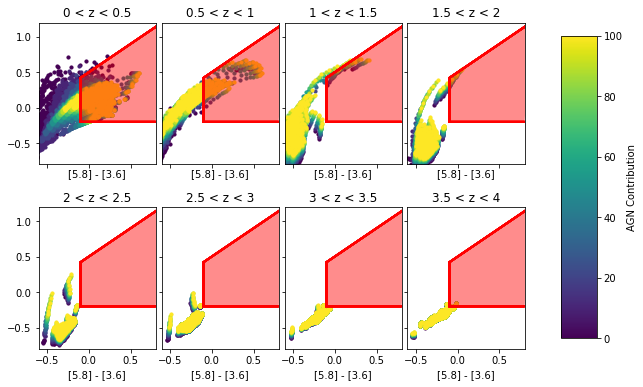

In [15]:
# In addition to the restframe we can also see how aritifically redshifting the galaxy affects the modelling of the SED - the lacy selection seems to break down at redshifts above 0.5
# 
# each entry in the table will be the completeness of the selection at that redshift
completeness_values = [[], [], [], [], [], [], [], []]


# Choose the diagram min and max
xmax = 0.8
ymax = 1.2
xmin = -0.6
ymin = -0.8

# Can change this to ensure we are only looking at the rest frame stuff
upper_redshift_limit = 0.5
lower_redshift_limit = 0

print(colours_theme)
# Redshift bins

bin_1 = [0, 0.5]
bin_2 = [0.5, 1]
bin_3 = [1, 1.5]
bin_4 = [1.5, 2]
bin_5 = [2, 2.5]
bin_6 = [2.5, 3]
bin_7 = [3, 3.5]
bin_8 = [3.5, 4]

# all bins
redshift_bins = [bin_1, bin_2, bin_3, bin_4, bin_5, bin_6, bin_7, bin_8]

# setup
fig, axs = plt.subplots(2, 4, figsize=fig_size_params, sharex=True, sharey=True)

for n in range(len(redshift_bins)):
    lower_redshift_limit = redshift_bins[n][0]
    upper_redshift_limit = redshift_bins[n][1]
    # We want an AGN evolution plot for
    for m in range(len(alpha_values)):
        
        # Show the upper and lower redshift limits
        axs[n//4, n%4].set_title(f"{lower_redshift_limit} < z < {upper_redshift_limit}")
        
        
        # Get the IRAC magnitudes
        f_36 = composite_fluxes[f'IRAC3.6_{alpha_values[m]}']
        f_45 = composite_fluxes[f'IRAC4.5_{alpha_values[m]}']
        f_58 = composite_fluxes[f'IRAC5.8_{alpha_values[m]}']
        f_80 = composite_fluxes[f'IRAC8.0_{alpha_values[m]}']
        
        # Create the colours for the IRAC diagram
        f_5836_specific_alpha_colours = np.log10(f_58/f_36)
        f_8045_specific_alpha_colours = np.log10(f_80/f_45)
        
        # Redefine x and y for the first alpha value to plot the wedge
        x = f_5836_specific_alpha_colours
        y = f_8045_specific_alpha_colours
        
        # Can change this to ensure we are only looking at the rest frame stuff
        x = x[(composite_fluxes['z'] >= lower_redshift_limit) & (composite_fluxes['z'] <= upper_redshift_limit)]
        y = y[(composite_fluxes['z'] >= lower_redshift_limit) & (composite_fluxes['z'] <= upper_redshift_limit)]
        
        # Reimplement the selection criteria 
        lacy_selection_condition = (x > -0.1) & (y > -0.2) & (y < 0.8 * x + 0.5)
        
        # Colour code for each alpha
        axs[n//4, n%4].scatter(x, y, c=[colours_theme[m]], s=10)
            
        
        num_sources_selected = x[lacy_selection_condition].notna().sum()

        
        
        if m == 0:
            num_sources_all = len(x)
            completeness = num_sources_selected/num_sources_all
            
        else:
            completeness = num_sources_selected/num_sources_all
            
            # Add the completeness value to the list, for the redshift bin
            completeness_values[n].append({'alpha': alpha_values[m], 'completeness': completeness})    
        
        
         # # Get the IRAC magnitudes
        f_36 = composite_fluxes[f'IRAC3.6_{alpha_values[0]}']
        f_45 = composite_fluxes[f'IRAC4.5_{alpha_values[0]}']
        f_58 = composite_fluxes[f'IRAC5.8_{alpha_values[0]}']
        f_80 = composite_fluxes[f'IRAC8.0_{alpha_values[0]}']

        # Create the colours for the IRAC diagram
        f_5836_specific_alpha_colours = np.log10(f_58/f_36)
        f_8045_specific_alpha_colours = np.log10(f_80/f_45)
        
        x = f_5836_specific_alpha_colours
        y = f_8045_specific_alpha_colours
        
                
        # Ensure a consistent selection region defined by the first redshift bin
        x = x[(composite_fluxes['z'] >= redshift_bins[0][0]) & (composite_fluxes['z'] <= redshift_bins[0][1])]
        y = y[(composite_fluxes['z'] >= redshift_bins[0][0]) & (composite_fluxes['z'] <= redshift_bins[0][1])]
        
        # Reimplement the selection criteria
        lacy_selection_condition = (x > -0.1) & (y > -0.2) & (y < 0.8 * x + 0.5)        
        
        wedge_vertices = [
            (xmax, -0.2),
            (-0.1, -0.2),
            (-0.1, 0.8*np.nanmin(x[lacy_selection_condition]) + 0.5 if np.any(lacy_selection_condition) else -0.2),  # Handle empty selection
            (((ymax-0.5)/0.8), ymax)
        ]
        

        axs[n//4, n%4].add_patch(plt.Polygon(wedge_vertices, closed=False, edgecolor='r', facecolor=(1,0,0,0.05), linestyle='-', linewidth=2, label='Lacy Wedge'))

        # Set the axis labels
        axs[n//4, n%4].set_xlabel("[5.8] - [3.6]")


        # Set the axis limits
        axs[n//4, n%4].set_xlim(xmin, xmax)
        axs[n//4, n%4].set_ylim(ymin, ymax)

        # # Add a colorbar for the AGN contribution
        # sm = plt.cm.ScalarMappable(cmap=plt.cm.viridis, norm=plt.Normalize(vmin=min(alpha_values), vmax=max(alpha_values)))
        # cbar = plt.colorbar(sm, ax=axs[n//4, n%4])

        # # Add the colorbar label
        # cbar.set_label('AGN Contribution')

# Show a single colorbar for the entire plot
fig.subplots_adjust(right=0.8)
cbar_ax = fig.add_axes([0.85, 0.15, 0.05, 0.7])
sm = plt.cm.ScalarMappable(cmap=plt.cm.viridis, norm=plt.Normalize(vmin=min(alpha_values), vmax=max(alpha_values)))
cbar = fig.colorbar(sm, cax=cbar_ax)
cbar.set_label('AGN Contribution')

       
        
    
        
# Make the subplots closer together
plt.subplots_adjust(wspace=0.05, hspace=0.3)
    
# Save the output
if save_figures:
    
    plt.savefig(f'outputs/ThesisPlots/IRAC_AGNRedshift_evolution_{agn_model_name}_{template_set_name}.png')
     
# Show the output
plt.show()

In [16]:
# Check the redshift completeness outputs for each redshift bin

# Print the results
for n in range(len(redshift_bins)):
    print(f"Redshift Bin: {redshift_bins[n]}")
    completeness_df = pd.DataFrame(completeness_values[n])
    print(completeness_df)
    print("\n\n")
    
    # Save the completeness values for each redshift bin
    if save_figures:
        completeness_df.to_csv(f'outputs/redshift_bins/IRAC_completeness_{agn_model_name}_{template_set_name}_z_{redshift_bins[n][0]}_{redshift_bins[n][1]}.csv')

Redshift Bin: [0, 0.5]
   alpha  completeness
0     10      0.144531
1     20      0.229167
2     30      0.319010
3     40      0.412760
4     50      0.507812
5     60      0.602865
6     70      0.697917
7     80      0.765625
8     90      0.802083
9    100      0.852865



Redshift Bin: [0.5, 1]
   alpha  completeness
0     10      0.011719
1     20      0.015625
2     30      0.022135
3     40      0.028646
4     50      0.042969
5     60      0.062500
6     70      0.075521
7     80      0.096354
8     90      0.114583
9    100      0.134115



Redshift Bin: [1, 1.5]
   alpha  completeness
0     10      0.007812
1     20      0.007812
2     30      0.007812
3     40      0.007812
4     50      0.007812
5     60      0.006510
6     70      0.006510
7     80      0.006510
8     90      0.005208
9    100      0.005208



Redshift Bin: [1.5, 2]
   alpha  completeness
0     10      0.001302
1     20      0.001302
2     30      0.002604
3     40      0.002604
4     50      0.002604
5 

# Brown Templates Average Moving Position
We would also like to see some other metrics. For example we would like to see how far each of the points oved in space in each diagram and for each model type (Type 1, Type 2)

What the values in this table will represent are the average change in position from the initial starting position. I.e the offset from the initial position.

Showing agn contribution and movement


In [17]:
# Read in both the type 1 and type 2 AGN models
template_set_name = 'Brown'
agn_model_names = ['Type1AGN', 'Type2AGN']


# read in the dataframe and ensure that the unamed: 0 column is the index
composite_choice_1 = f'{template_set_name}_theoretical_composite_fluxes_{agn_model_names[0]}'
composite_choice_2 = f'{template_set_name}_theoretical_composite_fluxes_{agn_model_names[1]}'
composite_fluxes_type1 = pd.read_csv(f'outputs\composite_seds\{composite_choice_1}.csv', index_col=0)   
composite_fluxes_type2 = pd.read_csv(f'outputs\composite_seds\{composite_choice_2}.csv', index_col=0)   


In [18]:
composite_fluxes_type1

,id,z,U_0,U_10,U_20,U_30,U_40,U_50,U_60,U_70,...,r_10,r_20,r_30,r_40,r_50,r_60,r_70,r_80,r_90,r_100
0,Arp_118,0.0,-21.198908,-21.315776,-21.421279,-21.517432,-21.605757,-21.687435,-21.763396,-21.834388,...,-23.454779,-23.475153,-23.495151,-23.514788,-23.534076,-23.553028,-23.571654,-23.589966,-23.607974,-23.625689
1,Arp_256_N,0.0,-20.237172,-20.287567,-20.335726,-20.381839,-20.426074,-20.468576,-20.509478,-20.548894,...,-21.492481,-21.513877,-21.534859,-21.555444,-21.575645,-21.595478,-21.614955,-21.634088,-21.652890,-21.671372
2,Arp_256_S,0.0,-20.201401,-20.302567,-20.395105,-20.480372,-20.559427,-20.633115,-20.702117,-20.766996,...,-21.460665,-21.504041,-21.545751,-21.585917,-21.624651,-21.662050,-21.698203,-21.733192,-21.767088,-21.799958
3,CGCG_049-057,0.0,-17.401194,-17.657027,-17.863926,-18.037638,-18.187352,-18.318902,-18.436221,-18.542091,...,-19.901468,-19.939198,-19.975661,-20.010938,-20.045106,-20.078231,-20.110376,-20.141596,-20.171943,-20.201465
4,CGCG_436-030,0.0,-20.094718,-20.244207,-20.375583,-20.492764,-20.598521,-20.694885,-20.783389,-20.865219,...,-21.546386,-21.601016,-21.653028,-21.702663,-21.750127,-21.795603,-21.839250,-21.881211,-21.921609,-21.960559
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
123,UGC_09618_N,3.9,37.371478,28.856104,28.103742,27.663585,27.351274,27.109020,26.911081,26.743724,...,27.953385,27.384060,27.012499,26.736186,26.516120,26.333229,26.176750,26.040009,25.918579,25.809374
124,UGC_09618,3.9,36.333443,28.487211,27.735031,27.294934,26.982653,26.740418,26.542491,26.375143,...,27.182581,26.759907,26.456444,26.219535,26.025174,25.860380,25.717334,25.590959,25.477772,25.375279
125,UGC_09618_S,3.9,34.982780,29.716301,28.967982,28.529176,28.217541,27.975693,27.778025,27.610862,...,27.645340,27.417662,27.229551,27.069268,26.929633,26.805926,26.694884,26.594152,26.501977,26.417019
126,UGC_12150,3.9,38.434321,29.718392,28.965994,28.525825,28.213508,27.971250,27.773309,27.605950,...,29.110326,28.410883,27.988959,27.685882,27.449206,27.255002,27.090322,26.947361,26.821052,26.707918


In [19]:
composite_fluxes_type2

,id,z,U_0,U_10,U_20,U_30,U_40,U_50,U_60,U_70,...,r_10,r_20,r_30,r_40,r_50,r_60,r_70,r_80,r_90,r_100
0,Arp_118,0.0,-21.198908,-21.198975,-21.199042,-21.199109,-21.199176,-21.199243,-21.199310,-21.199377,...,-23.434047,-23.434078,-23.434109,-23.434140,-23.434171,-23.434202,-23.434233,-23.434264,-23.434295,-23.434326
1,Arp_256_N,0.0,-20.237172,-20.237200,-20.237228,-20.237256,-20.237284,-20.237312,-20.237340,-20.237368,...,-21.470688,-21.470720,-21.470753,-21.470786,-21.470818,-21.470851,-21.470884,-21.470917,-21.470949,-21.470982
2,Arp_256_S,0.0,-20.201401,-20.201459,-20.201517,-20.201574,-20.201632,-20.201690,-20.201747,-20.201805,...,-21.415551,-21.415620,-21.415688,-21.415757,-21.415825,-21.415894,-21.415962,-21.416031,-21.416099,-21.416167
3,CGCG_049-057,0.0,-17.401194,-17.401350,-17.401506,-17.401662,-17.401818,-17.401974,-17.402130,-17.402286,...,-19.862438,-19.862497,-19.862555,-19.862614,-19.862673,-19.862731,-19.862790,-19.862849,-19.862907,-19.862966
4,CGCG_436-030,0.0,-20.094718,-20.094805,-20.094892,-20.094979,-20.095066,-20.095153,-20.095240,-20.095327,...,-21.488948,-21.489035,-21.489123,-21.489210,-21.489298,-21.489385,-21.489473,-21.489560,-21.489647,-21.489735
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
123,UGC_09618_N,3.9,37.371478,37.095493,36.875635,36.692888,36.536515,36.399853,36.278486,36.169333,...,29.222563,29.222281,29.221999,29.221717,29.221435,29.221153,29.220872,29.220590,29.220308,29.220027
124,UGC_09618,3.9,36.333443,36.175846,36.038252,35.916150,35.806402,35.706737,35.615456,35.531257,...,27.884020,27.883905,27.883789,27.883674,27.883558,27.883443,27.883328,27.883212,27.883097,27.882981
125,UGC_09618_S,3.9,34.982780,34.967244,34.951927,34.936823,34.921927,34.907232,34.892733,34.878426,...,27.933748,27.933709,27.933670,27.933632,27.933593,27.933554,27.933516,27.933477,27.933438,27.933400
126,UGC_12150,3.9,38.434321,38.111938,37.863686,37.661767,37.491576,37.344482,37.214960,37.099255,...,31.658945,31.657752,31.656559,31.655368,31.654178,31.652990,31.651803,31.650617,31.649432,31.648249


In [20]:

# Create the a table where it is 

#            | Alpha | 0 | 10 | 20 | 30 | 40 | 50 | 60 | 70 | 80 | 90 | 100 
# Vector Mag | Type 1|
#   Diff     | Type 2|

# Create table
vector_magnitude_table = pd.DataFrame(columns=alpha_values[1:], index=['Type 1', 'Type 2'])



# types
types = ['Type 1', 'Type 2']

for type in types: 
    if type == 'Type 1':
        composite_fluxes = composite_fluxes_type1
    else:
        composite_fluxes = composite_fluxes_type2
        
    for alpha in alpha_values:
        # Get the filter magnitudes
        U_mag = composite_fluxes[f'U_{alpha}']
        V_mag = composite_fluxes[f'V_{alpha}']
        J_mag = composite_fluxes[f'J_{alpha}']

        # Create the colours
        uv = U_mag - V_mag
        vj = V_mag - J_mag

        # Recall that this is only a restframe diagram, so only look at the restframe colours
        uv = uv[composite_fluxes['z'] == 0]
        vj = vj[composite_fluxes['z'] == 0]
        
        if alpha == 0:
            # uv and vj initial values
            uv_initial = uv
            vj_initial = vj
            
            # Get the average location
            uv_mean_inital = np.mean(uv_initial)
            vj_mean_inital = np.mean(vj_initial)
            
            # print the mean location
            #print(f"Mean Location for alpha = {alpha_values[m]}: ({vj_mean_inital}, {vj_mean_inital})")
            
        else:
            # Get the vector magnitude
            # Get the average location
            uv_mean = np.mean(uv)
            vj_mean = np.mean(vj)
            
            # print the mean location
            #print(f"Mean Location for alpha = {alpha_values[m]}: ({vj_mean}, {uv_mean})")
            
            # calculate the absolute vector magnitude difference
            vector_magnitude_diff = np.sqrt((vj_mean - vj_mean_inital)**2 + (uv_mean - uv_mean_inital)**2)
                
            # Add the vector magnitude to the table
            vector_magnitude_table.loc[type, alpha] = vector_magnitude_diff


if save_figures:
    vector_magnitude_table.to_csv(f'outputs/ThesisPlots/UVJ_VectorMagnitudeDifference_{agn_model_names[0]}_{agn_model_names[1]}.csv')
   
   
# Check the output
vector_magnitude_table

,10,20,30,40,50,60,70,80,90,100
Type 1,0.079258,0.145754,0.203402,0.254316,0.299865,0.341011,0.37847,0.412792,0.444408,0.473669
Type 2,0.000191,0.000383,0.000574,0.000765,0.000955,0.001146,0.001337,0.001527,0.001718,0.001908


Now we know this works, we do the same for the other colour spaces.

In [21]:
# ugr space
vector_magnitude_table = pd.DataFrame(columns=alpha_values[1:], index=['Type 1', 'Type 2'])

for type in types:
    if type == 'Type 1':
        composite_fluxes = composite_fluxes_type1
    else:
        composite_fluxes = composite_fluxes_type2
        
    for alpha in alpha_values:
        # Get the u, g, and r magnitudes for the specific alpha value
        u_col_name = f'u_{int(round(alpha, 2))}'
        g_col_name = f'g_{int(round(alpha, 2))}'
        r_col_name = f'r_{int(round(alpha, 2))}'

        # Create the colours for the UGR diagram
        ug_specific_alpha_colours = composite_fluxes[u_col_name] - composite_fluxes[g_col_name]
        gr_specific_alpha_colours = composite_fluxes[g_col_name] - composite_fluxes[r_col_name]


        if alpha == 0:
            # uv and vj initial values
            ug_initial = ug_specific_alpha_colours
            gr_initial = gr_specific_alpha_colours
            
            # Get the average location
            ug_mean_inital = np.mean(ug_initial)
            gr_mean_inital = np.mean(gr_initial)
            
            # print the mean location
            #print(f"Mean Location for alpha = {alpha_values[m]}: ({vj_mean_inital}, {vj_mean_inital})")
            
        else:
            # Get the vector magnitude
            # Get the average location
            ug_mean = np.mean(ug_specific_alpha_colours)
            gr_mean = np.mean(gr_specific_alpha_colours)
            
            # print the mean location
            #print(f"Mean Location for alpha = {alpha_values[m]}: ({vj_mean}, {uv_mean})")
            
            # calculate the absolute vector magnitude difference
            vector_magnitude_diff = np.sqrt((ug_mean - ug_mean_inital)**2 + (gr_mean - gr_mean_inital)**2)
                
            # Add the vector magnitude to the table
            vector_magnitude_table.loc[type, alpha] = vector_magnitude_diff
            
if save_figures:
    vector_magnitude_table.to_csv(f'outputs/ThesisPlots/UGR_VectorMagnitudeDifference_{agn_model_names[0]}_{agn_model_names[1]}.csv')
    
# Check the output
vector_magnitude_table



,10,20,30,40,50,60,70,80,90,100
Type 1,1.109559,1.250554,1.32764,1.379186,1.417108,1.446637,1.470521,1.490375,1.507223,1.521755
Type 2,0.017326,0.028749,0.038168,0.046395,0.053795,0.060569,0.066849,0.072723,0.078255,0.083495


Lastly we look at the IRAC colour space - here we expect less of an effect as the IRAC colour space from Type 1, but more from Type 2.


In [22]:
# IRAC space
vector_magnitude_table = pd.DataFrame(columns=alpha_values[1:], index=['Type 1', 'Type 2'])

for type in types:
    if type == 'Type 1':
        composite_fluxes = composite_fluxes_type1
    else:
        composite_fluxes = composite_fluxes_type2
        
    for alpha in alpha_values:
        # Get the IRAC magnitudes
        f_36 = composite_fluxes[f'IRAC3.6_{alpha}']
        f_45 = composite_fluxes[f'IRAC4.5_{alpha}']
        f_58 = composite_fluxes[f'IRAC5.8_{alpha}']
        f_80 = composite_fluxes[f'IRAC8.0_{alpha}']

        # Create the colours for the IRAC diagram
        f_5836_specific_alpha_colours = np.log10(f_58/f_36)
        f_8045_specific_alpha_colours = np.log10(f_80/f_45)

        if alpha == 0:
            # uv and vj initial values
            f_5836_initial = f_5836_specific_alpha_colours
            f_8045_initial = f_8045_specific_alpha_colours
            
            # Get the average location
            f_5836_mean_inital = np.mean(f_5836_initial)
            f_8045_mean_inital = np.mean(f_8045_initial)
            
            # print the mean location
            #print(f"Mean Location for alpha = {alpha_values[m]}: ({vj_mean_inital}, {vj_mean_inital})")
            
        else:
            # Get the vector magnitude
            # Get the average location
            f_5836_mean = np.mean(f_5836_specific_alpha_colours)
            f_8045_mean = np.mean(f_8045_specific_alpha_colours)
            
            # print the mean location
            #print(f"Mean Location for alpha = {alpha_values[m]}: ({vj_mean}, {uv_mean})")
            
            # calculate the absolute vector magnitude difference
            vector_magnitude_diff = np.sqrt((f_5836_mean - f_5836_mean_inital)**2 + (f_8045_mean - f_8045_mean_inital)**2)
                
            # Add the vector magnitude to the table
            vector_magnitude_table.loc[type, alpha] = vector_magnitude_diff
            
if save_figures:
    vector_magnitude_table.to_csv(f'outputs/ThesisPlots/IRAC_VectorMagnitudeDifference_{agn_model_names[0]}_{agn_model_names[1]}.csv')
    
# Check the output
vector_magnitude_table


,10,20,30,40,50,60,70,80,90,100
Type 1,0.035818,0.062464,0.084242,0.102755,0.118875,0.133149,0.145946,0.157531,0.168102,0.17781
Type 2,0.060365,0.098901,0.128623,0.153148,0.174166,0.192631,0.209141,0.224101,0.237797,0.250441


In [23]:
# composite_fluxes = composite_fluxes_type1

# # Gen figure
# fig, axs = plt.subplots(1, 1, figsize=fig_size_params)

# # Set figure limits
# axs.set_xlim(-0.5, 2.5)
# axs.set_ylim(0, 2.5)


# for m in range(len(alpha_values)):
    
    
    
    
#     # Get the filter magnitudes
#     U_mag = composite_fluxes[f'U_{alpha_values[m]}']
#     V_mag = composite_fluxes[f'V_{alpha_values[m]}']
#     J_mag = composite_fluxes[f'J_{alpha_values[m]}']
    
#     # Create the colours
#     uv = U_mag - V_mag
#     vj = V_mag - J_mag
    
#     # Recall that this is only a restframe diagram, so only look at the restframe colours
#     uv = uv[composite_fluxes['z'] == 0]
#     vj = vj[composite_fluxes['z'] == 0]
    
    
#     # Find the inital position in the UVJ
#     if m == 0:
        
#         # uv and vj initial values
#         uv_initial = uv
#         vj_initial = vj
        
#         # Get the average location
#         uv_mean_inital = np.mean(uv_initial)
#         vj_mean_inital = np.mean(vj_initial)
        
#         # print the mean location
#         print(f"Mean Location for alpha = {alpha_values[m]}: ({vj_mean}, {uv_mean})")
        
#         # Plot the mean location
#         axs.scatter(vj_mean_inital, uv_mean_inital, c='red', s=20)
        
#     else: 
        
#         # Get the average location
#         uv_mean = np.mean(uv)
#         vj_mean = np.mean(vj)
        
#         # print the mean location
#         print(f"Mean Location for alpha = {alpha_values[m]}: ({vj_mean}, {uv_mean})")
        
#         # Plot the mean location
#         axs.scatter(vj_mean, uv_mean, c='red', s=20)
        
#         # calculate the absolute vector magnitude difference
#         vector_magnitude_diff = np.sqrt((vj_mean - vj_mean_inital)**2 + (uv_mean - uv_mean_inital)**2)
        
#         # Print the vector magnitude difference
#         print(f"Vector Magnitude Difference for alpha = {alpha_values[m]}: {vector_magnitude_diff}")

        
#     # Plot scatter
#     axs.scatter(vj, uv, c='grey', s=10)
    
    
# # Add patches for selections
# axs.add_patch(plt.Polygon(path_quiescent, closed=True, fill=True, facecolor=(1, 0, 0, 0.03), edgecolor='k', linewidth=2, linestyle='solid'))
# axs.add_patch(plt.Polygon(path_sf, closed=True, fill=True, facecolor=(0, 0, 1, 0.03)))
# axs.add_patch(plt.Polygon(path_sfd, closed=True, fill=True, facecolor=(1, 1, 0, 0.03)))

# # Add vertical line
# axs.axvline(1.2, color='black', linestyle='--', ymin=0, ymax=1.60333/2.5)

# # Add axis labels
# axs.set_xlabel("V - J")

# # AGN Colour Evolution title
# axs.set_title("Colour Evolution")



# # Plot colorbar for AGN contribution
# sm = plt.cm.ScalarMappable(cmap=plt.cm.viridis, norm=plt.Normalize(vmin=min(alpha_values), vmax=max(alpha_values)))
# cbar = plt.colorbar(sm, ax=axs)

# # Name the colorbar
# cbar.set_label('AGN Contribution')

    
# # Make the subplots closer together
# plt.subplots_adjust(wspace=0.05, hspace=0.3)
    

# # Save the output
# if save_figures:
#     plt.savefig(f'outputs/ThesisPlots/UVJ_evolution_{agn_model_name}_{template_set_name}.png')

# # Show the output
# plt.show()
